In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns

import cvxpy as cp

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [2]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 946702800, endDate = 1641013200


In [38]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)
pd.set_option('display.max_rows', 20 )
SP_Close

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,44.290768,0.859423,3.025872,18.250000,9.347848,16.274673,29.907148,6.713819,25.847559,8.052903,...,44.580296,1.073165,5.451856,33.677483,7.445601,19.671471,6.885552,4.861753,25.027779,39.500340
2000-01-04,40.907444,0.786965,2.819288,17.812500,9.080768,14.909401,28.394154,6.643884,25.847559,7.660817,...,42.912186,1.040144,5.508177,32.412312,7.617046,19.294678,6.885552,4.764031,24.666668,37.587597
2000-01-05,38.369949,0.798481,3.038026,18.000000,9.064072,15.204173,28.808693,6.538977,25.599030,7.178246,...,42.036419,1.023634,5.485647,34.129314,7.910954,20.346561,7.004584,4.788458,25.138889,37.543118
2000-01-06,36.908974,0.729382,3.268915,18.031250,9.381229,15.328290,28.021109,6.573947,25.940756,6.740915,...,42.495163,1.083071,5.429329,35.725838,7.837476,21.398420,7.013742,4.747740,23.777779,38.076908
2000-01-07,39.984726,0.763932,3.694239,17.937500,9.481392,16.072983,28.808693,6.678849,26.531019,7.540174,...,45.706280,1.066561,5.485647,34.551022,7.837476,21.335629,6.995429,4.641874,23.513889,38.165886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.531204,180.330002,131.471329,357.829987,140.403183,577.679993,175.470001,65.720932,245.068527,284.299988,...,139.709854,54.240002,465.444122,38.111694,66.356621,61.211414,55.950001,137.372253,606.330017,63.009998
2021-12-28,158.970612,179.289993,131.929840,357.440002,139.420593,569.359985,174.380005,66.576385,244.849625,282.769989,...,141.714783,54.646667,464.425049,38.303886,67.151077,61.013607,56.029999,137.342392,597.320007,63.110001
2021-12-29,160.438675,179.380005,132.906647,361.839996,140.135193,569.289978,175.520004,66.655968,246.779999,282.570007,...,141.645309,55.013332,467.542084,39.091873,67.488716,60.479530,56.650002,138.019257,601.119995,63.450001


## Testing Initial Portfolio without Bayes

In [17]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.970040,1.063362,11.317920,14.29,15.050684,29.384233,23.723516,14.685471,22.294916,34.282318,...,37.189411,6.190108,10.584786,37.669765,9.064568,28.189125,24.590631,12.140266,53.099998,50.710098
2005-01-10,13.902375,1.058910,11.317920,14.42,15.196438,29.404230,23.630089,14.806501,22.310614,34.222351,...,37.003422,6.218071,10.730639,37.825886,9.189455,28.296692,25.142307,12.142887,53.840000,50.741310
2005-01-11,13.662468,0.991345,11.345289,14.31,14.917607,29.054298,23.409874,14.598058,22.352489,32.373302,...,36.913902,6.222064,10.605621,37.469048,9.220678,28.223097,25.142307,12.182178,51.669998,50.772518
2005-01-12,13.644017,1.005166,11.349199,14.17,14.952656,29.484215,23.730200,14.503919,22.148378,31.953520,...,37.251400,6.263339,10.684804,37.368683,9.210266,28.642048,25.056398,12.085063,50.910000,50.296547
2005-01-13,13.354897,1.071809,11.161545,12.45,14.665900,29.104290,23.423223,14.692192,21.719227,31.763618,...,36.948334,6.277987,10.605621,37.106606,9.298730,28.619410,24.789597,11.911815,51.060001,49.711346


In [18]:
from pypfopt.efficient_frontier import EfficientFrontier


mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(ef.portfolio_performance(verbose=True))
print(cleaned_weights)

Expected annual return: 44.8%
Annual volatility: 13.5%
Sharpe Ratio: 3.16
(0.44839397465164277, 0.13546838153461138, 3.1623170646811825)
OrderedDict([('A', 0.0), ('AAPL', 0.0), ('ABC', 0.0), ('ABMD', 0.0), ('ABT', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEE', 0.0), ('AEP', 0.0), ('AES', 0.0), ('AFL', 0.0), ('AIG', 0.0), ('AJG', 0.0), ('AKAM', 0.0), ('ALB', 0.0), ('ALK', 0.0), ('ALL', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AME', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANSS', 0.0), ('AON', 0.0), ('AOS', 0.0), ('APA', 0.0), ('APD', 0.0), ('APH', 0.0), ('ARE', 0.0), ('ATO', 0.0), ('ATVI', 0.0), ('AVB', 0.0), ('AVY', 0.0), ('AXP', 0.0), ('AZO', 0.0), ('BA', 0.0), ('BAC', 0.0), ('BAX', 0.0), ('BBWI', 0.0), ('BBY', 0.0), ('BDX', 0.0), ('BEN', 0.0), ('BIIB', 0.0), ('BIO', 0.02052), ('BK', 0.0), ('BKNG', 0.0), ('BKR', 0.0), ('BLK', 0.0488), ('BLL', 0.0), ('BMY', 0.0), ('BRO', 0.0), ('BSX', 0.0), ('BWA', 0.0), ('BXP', 0.0), ('C', 0.0), ('CAG', 0.

## Look at some correlations and clustering to gather ideas

<Figure size 864x576 with 0 Axes>

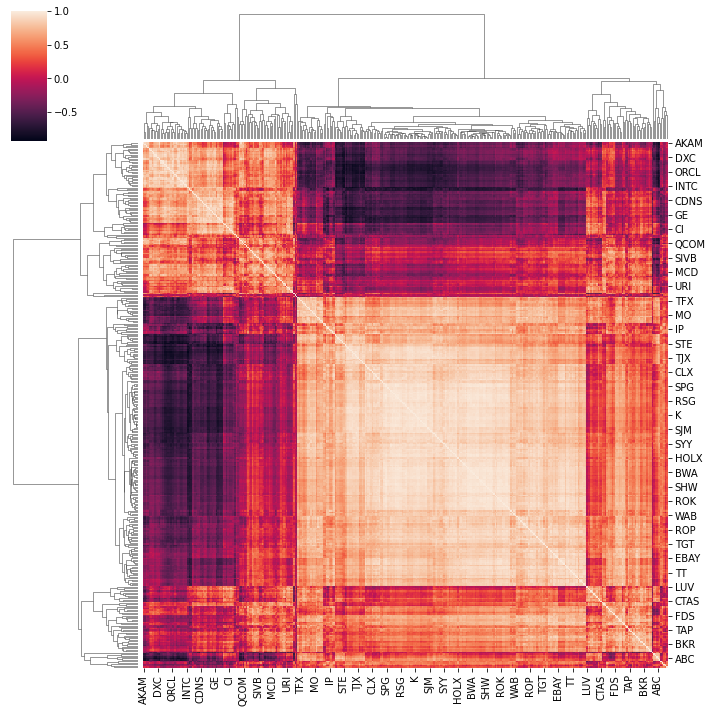

In [19]:
corr = five_year_data.corr()
plt.figure(figsize=(12,8))
sns.clustermap(corr)

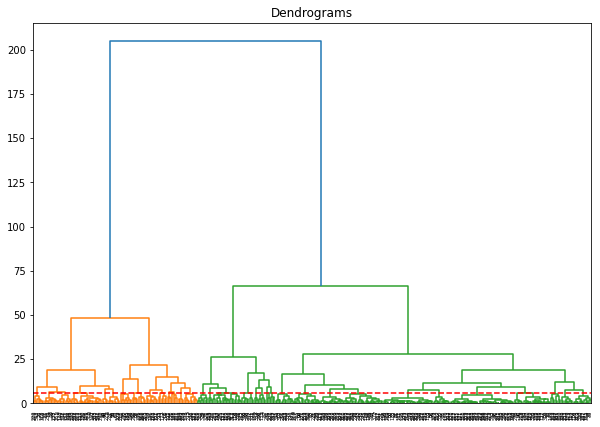

In [27]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [28]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=4)  
kclusters = cluster.fit_predict(corr)
stock_clusters=pd.DataFrame(SP_Close.columns.values)
stock_clusters=stock_clusters.set_index(0)
stock_clusters['cluster']=kclusters
print(stock_clusters['cluster'].max())

63


(array([ 8.,  5., 15.,  3.,  5.,  5.,  8.,  6.,  2.,  7.,  4.,  8.,  3.,
        11., 12.,  3.,  5.,  4., 18.,  2.,  5.,  9.,  3.,  4.,  3., 12.,
         3.,  4.,  5., 33.,  2., 23.,  9.,  7.,  6.,  4.,  2.,  5.,  5.,
         2.,  3.,  3.,  4.,  1.,  2.,  3.,  1.,  1.,  2.,  2.,  2.,  5.,
        19.,  1.,  4.,  4.,  4.,  2.,  2.,  3.,  2.,  5., 12.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.]),
 <BarContainer object of 63 artists>)

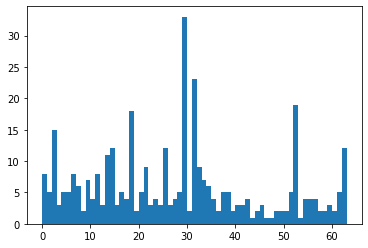

In [29]:
plt.hist(stock_clusters,bins=stock_clusters['cluster'].max())

In [30]:
def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()
    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s

#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))
    for ints,sector in enumerate(data
                                 .columns): 
        likelihood_pop = np.array(data.iloc[n-period : n - 1][sector])
        prior_pop = np.array(data.iloc[n-period : n - 1])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

## Correlation Clustering Algo

In [166]:
from sklearn.cluster import AgglomerativeClustering
#rule is to select number of clusters clusters such that at most stock_pct_thresh of stocks are in clusters 
#with an internal corr of corr_thresh

def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

def constrained_clusters(corr, corr_thresh = .7, stock_pct_thresh = .1,verbose=False):
    ix = -1 #start at highest threshold and move backward
    threshes = np.exp(np.arange(0,5,.05))#need a better system for this to make it not dependant on number of assets, 

    for i in range(len(threshes)):
        thresh = threshes[ix]
        stock_clusters = get_clusters(corr, Thresh = thresh)
        cluster_number = stock_clusters['cluster'].max()+1

        internal_corr_average = np.zeros([cluster_number])
        for n in range(cluster_number):
            cluster_corr = corr.loc[stock_clusters.loc[stock_clusters['cluster']==n].index,stock_clusters.loc[stock_clusters['cluster']==n].index]
            internal_corr_average[n] = cluster_corr.mean().mean()

        clustersWInternalCorrLessThanThreshold = np.argwhere(internal_corr_average<corr_thresh).flatten()
        percent_stocks_in_bad_clusters = len(stock_clusters.loc[stock_clusters['cluster'].isin(clustersWInternalCorrLessThanThreshold)])/len(stock_clusters)
        if percent_stocks_in_bad_clusters > stock_pct_thresh:
            ix-=1
        else:
            break
    if verbose:
        print("# of clusters:", cluster_number)
        print("percent of stocks in clusters with internal corr of less than corr_thresh:", percent_stocks_in_bad_clusters)

    #run clustering with chosen optimal method
    return get_clusters(corr, cluster_number = cluster_number), cluster_number


#test cluster corr

#temp = plt.hist(internal_corr_average,bins=15)
#plt.title("hist of ave of internal correlation matrices")
#plt.show()

## Markowitz Rebalancer

In [95]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [96]:
monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_Close,21,252*5,verbose=False) #monthly rebalance with 5 year matrix

In [145]:
def Portfolio_backtest(weight_vector) :
    return_frame = SP_Close.loc[weight_vector.index]
    return_frame = np.exp(np.log(return_frame).diff())-1
    weighted_returns=weight_vector.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    total_return=(port_returns+1).cumprod()
    total_return.plot()
    plt.title('Cumulative Return')

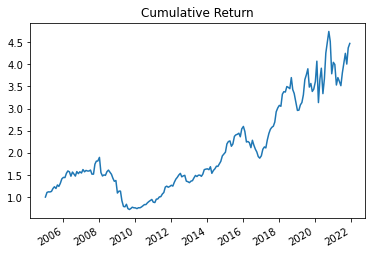

In [110]:
Portfolio_backtest(monthly_vanilla_markowitz)

## Implement Clustering Influenced Dynamic Constraints

In [113]:
initial_clusters=constrained_clusters(five_year_data.corr())

# of clusters: 38
percent of stocks in clusters with internal corr of less than corr_thresh: 0.08991825613079019


In [114]:
initial_clusters

,cluster
0,
A,0
AAPL,19
ABC,25
ABMD,12
ABT,16
...,...
XOM,7
XRAY,9
YUM,9


In [158]:
def Cluster_Constraints(clusters,weight_coef): # weight coef for how overweight you can go
    cluster_list = set(clusters.cluster)
    cluster_map = dict(zip(clusters.index,clusters.cluster))
    cluster_totals=[clusters.value_counts()[x] for x in cluster_list]
    cluster_pct=np.array(cluster_totals)/len(clusters)
    cluster_upper_l = dict(zip(cluster_list, cluster_pct*weight_coef))
    cluster_lower_l = dict(zip(cluster_list, - weight_coef*cluster_pct))
    return cluster_map, cluster_upper_l, cluster_lower_l

## Integrate clustering based Constraint

In [191]:
def Markowits_Bayes_Cluster_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1), cluster_coef=1.5,corr_thresh = .8):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    cluster_list=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        
        clusters, num =constrained_clusters(prior_vector.corr(),corr_thresh = corr_thresh)
        cluster_list.append(num)
        c_map, c_upper, c_lower = Cluster_Constraints(clusters,cluster_coef)
        
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        ef.add_sector_constraints(c_map, c_lower, c_upper)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    cluster_ts=pd.DataFrame(cluster_list)
    cluster_ts.index=dates
    cluster_ts.columns = ['Clusters']
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df, cluster_ts

In [ ]:
cluster_constrained_markowitz, cluster_num = Markowits_Bayes_Cluster_Rebalance(SP_Close,21*6,252*5,verbose=False)

C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector constraints may not produce reasonable results if shorts are allowed.
  warnings.warn(
C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector constraints may not produce reasonable results if shorts are allowed.
  warnings.warn(
C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector constraints may not produce reasonable results if shorts are allowed.
  warnings.warn(
C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector constraints may not produce reasonable results if shorts are allowed.
  warnings.warn(
C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector constraints may not produce reasonable results if shorts are allowed.
  warnings.warn(
C:\Users\evank\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:382: UserWarning: Sector c

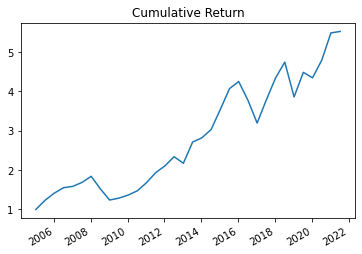

In [ ]:
Portfolio_backtest(cluster_constrained_markowitz)

In [ ]:
min(cluster_num.Clusters)

2

In [195]:
cluster_num

,Clusters
2005-01-06,79
2005-07-08,76
2006-01-06,60
2006-07-10,49
2007-01-09,60
...,...
2019-07-16,66
2020-01-14,76
2020-07-15,74
2021-01-13,49
